Imports nécessaires

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

Chargement du dataset

In [ ]:
df = pd.read_csv('Skin_Type_OG.csv')
df


,Age,Gender,Hydration_Level,Oil_Level,Sensitivity,Humidity,Temperature,Skin_Type
0,36,Male,Low,Low,High,31.9,10.1,Dry
1,36,Female,High,Low,High,30.1,20.5,Combination
2,34,Female,High,Medium,Low,53.0,19.5,Normal
3,51,Male,Medium,High,Low,57.3,22.7,Oily
4,36,Male,High,Medium,Medium,64.4,24.0,Normal
...,...,...,...,...,...,...,...,...
1995,27,Male,Medium,Medium,Medium,63.4,17.3,Normal
1996,59,Male,Medium,Medium,Low,55.9,16.0,Normal
1997,35,Female,Medium,High,Low,49.6,26.8,Oily
1998,36,Male,Medium,Medium,Medium,51.0,23.5,Normal


#Data cleaning

Valeurs manquantes

In [ ]:
df.isnull().sum()


,0
Age,0
Gender,0
Hydration_Level,0
Oil_Level,0
Sensitivity,0
Humidity,0
Temperature,0
Skin_Type,0


Duplicates

In [ ]:
df.duplicated().sum()

np.int64(0)

#Exploration du dataset

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2000 non-null   int64  
 1   Gender           2000 non-null   object 
 2   Hydration_Level  2000 non-null   object 
 3   Oil_Level        2000 non-null   object 
 4   Sensitivity      2000 non-null   object 
 5   Humidity         2000 non-null   float64
 6   Temperature      2000 non-null   float64
 7   Skin_Type        2000 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 125.1+ KB


,Age,Humidity,Temperature
count,2000.000000,2000.000000,2000.000000
mean,38.721000,48.686400,20.636400
std,11.951049,15.830841,5.831158
min,18.000000,20.000000,10.000000
25%,29.000000,36.200000,16.200000
50%,39.000000,47.700000,20.400000
75%,49.000000,61.125000,24.800000
max,59.000000,80.000000,34.900000


Histogrammes des variables numériques

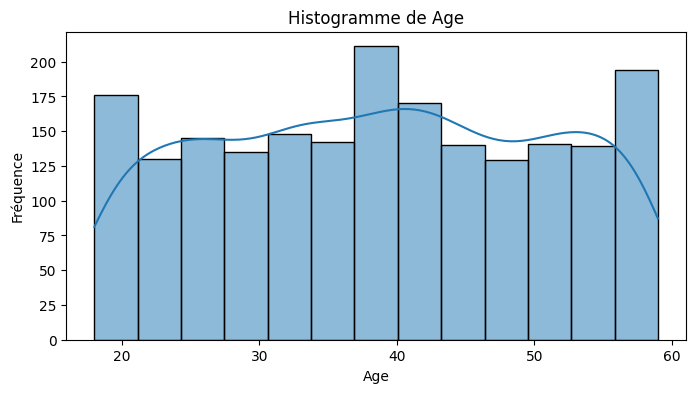

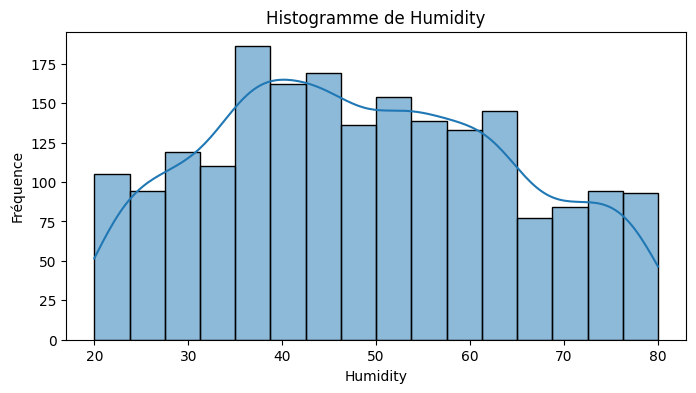

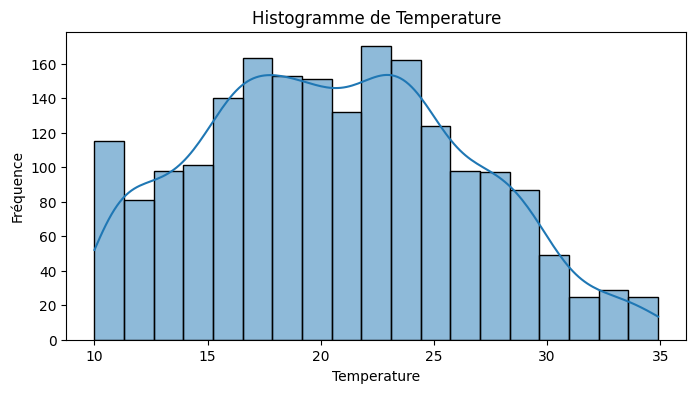

In [ ]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogramme de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')
    plt.show()


Distribution des types de peau



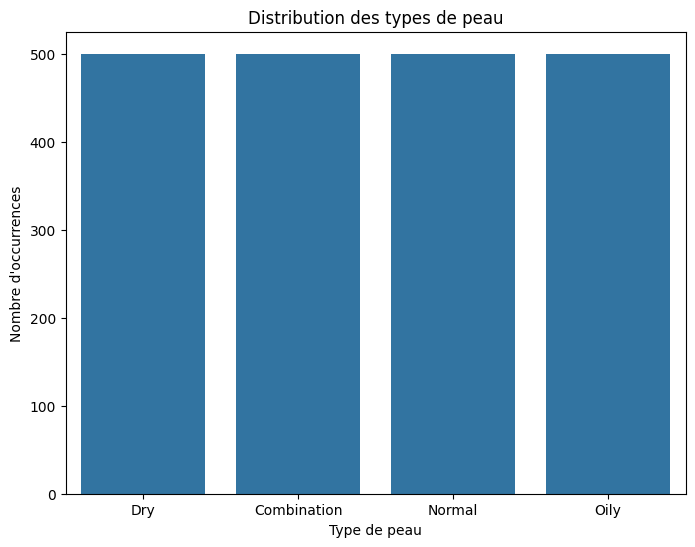

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Skin_Type', data=df, order=df['Skin_Type'].value_counts().index)
plt.title('Distribution des types de peau')
plt.xlabel('Type de peau')
plt.ylabel('Nombre d\'occurrences')
plt.show()

On a le même nombre de peaux sèches, mixte, normale et grasse.

Corrélations numériques (Âge, Humidity & Temperature)
On transforme les valeurs low, medium et high en nombres 0,1 et 2
Ne pas éxecuter 2 fois, sinon les valeurs passent à Nan!

In [ ]:
ordinal_cols = ["Hydration_Level", "Oil_Level", "Sensitivity"]

for col in ordinal_cols:
    df[col] = df[col].map({"Low":0, "Medium":1, "High":2})

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2000 non-null   int64  
 1   Gender           2000 non-null   object 
 2   Hydration_Level  2000 non-null   int64  
 3   Oil_Level        2000 non-null   int64  
 4   Sensitivity      2000 non-null   int64  
 5   Humidity         2000 non-null   float64
 6   Temperature      2000 non-null   float64
 7   Skin_Type        2000 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 125.1+ KB


,Age,Gender,Hydration_Level,Oil_Level,Sensitivity,Humidity,Temperature,Skin_Type
0,36,Male,0,0,2,31.9,10.1,Dry
1,36,Female,2,0,2,30.1,20.5,Combination
2,34,Female,2,1,0,53.0,19.5,Normal
3,51,Male,1,2,0,57.3,22.7,Oily
4,36,Male,2,1,1,64.4,24.0,Normal


On va encoder nos variabales Gender et Skin_Type

In [ ]:
le_gender = LabelEncoder()
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])
le_skin = LabelEncoder()
df['Skin_Type_encoded'] = le_skin.fit_transform(df['Skin_Type'])


Pour créer des clusters on va prendre toutes les colonnes sauf Skin-Type car c'est du label.

In [ ]:
features = df[['Age', 'Hydration_Level', 'Oil_Level', 'Sensitivity',
                 'Humidity', 'Temperature', 'Gender_encoded']]


#Ensuite on va standardiser pour KMeans
StandardScaler prend chaque colonne numérique (Age, Hydration_Level, Humidity…)
et les transforme pour qu’elles aient :

une moyenne = 0 &
un écart-type = 1

##Pourquoi on fait ça ?

Parce que dans du clustering (surtout K-means) :
si Age vaut 50 mais Sensitivity vaut 2 --> l'Age devient 25 fois plus important
C'est comme si le cluster se basait surtout sur l’âge --> pas bon

--> on met toutes les variables sur le même pied d’égalité.

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Puis on va faire la méthode du coude

array([0.37553666, 0.14760752])

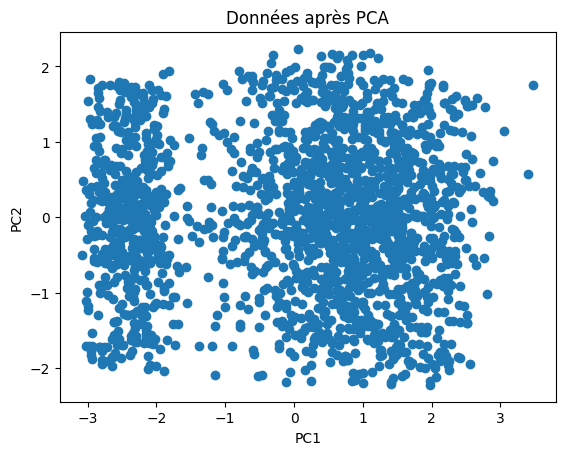

In [ ]:
X_scaled = features_scaled
y = df['Skin_Type_encoded']

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title('Données après PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

explained = pca.explained_variance_ratio_
explained


#Méthode du coude !!!!!!!!!!!!!!!!

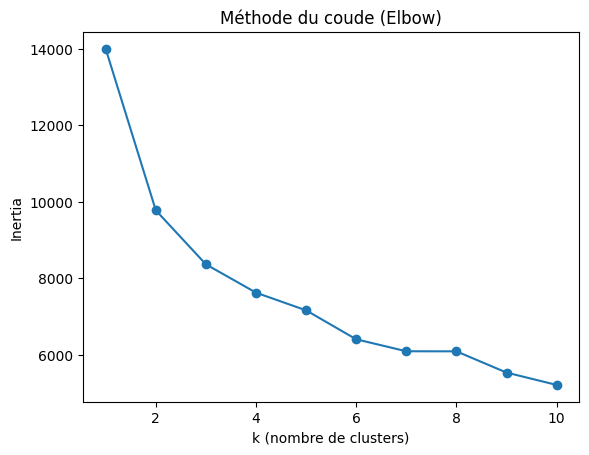

In [ ]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('k (nombre de clusters)')
plt.ylabel('Inertia')
plt.title('Méthode du coude (Elbow)')
plt.show()


Ici la courbe semble se casser en k=3 donc on va prendre k=3 pour la suite.

#K-Means(k=3)

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans.fit(X_scaled)
labels_km = kmeans.labels_

# Silhouette score sur les données standardisées (ou originales)
sil_km = silhouette_score(X_scaled, labels_km)
sil_km

np.float64(0.2954295040992432)

On a mis k=3 sauf qu'on a np.float64(0.2477697098167993) ce qui est faible.
-1 mauvais, 0 indifférent, +1 super

Pour trouver le meilleur k on va refaire le test des silouhettes de 2 à 10.

k=2 np.float64(0.2954295040992432)

k=4 np.float64(0.23450094163527502)

k=5 np.float64(0.1855095452523833)

Notre meilleure option semble être k=2 mais ça reste médiocre...

On revisualise dans l'espace PCA

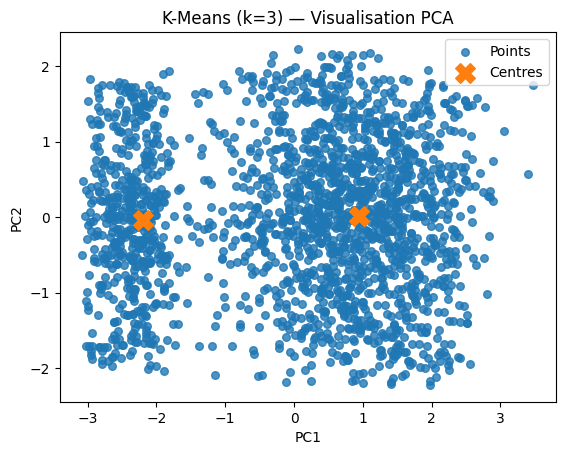

In [ ]:
# Visualisation dans l'espace PCA
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=30, alpha=0.8, label="Points")
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="X", s=200, label="Centres")
plt.title("K-Means (k=3) — Visualisation PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


On voit que les clusters ne sont pas bien séparé donc on va passer à l'utilisation de DBSCAN qui est utile quand les clusters ont une forme complexe.

#DBSCAN

In [ ]:
# Essayez différents eps si nécessaire
dbscan = DBSCAN(eps=2, min_samples=3)
dbscan.fit(X_scaled)
labels_db = dbscan.labels_

# Nombre de clusters (hors bruit -1)
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
prop_noise = (labels_db == -1).mean()

n_clusters_db, prop_noise


(2, np.float64(0.0005))

On teste eps=0.1 et on a (0, np.float64(1.0)) ce qui signifie 100% de bruit --> 0 clusters. On va essayer avec d'autres données eps.


Pour eps=1.2 et min_samples=3 --> (54, np.float64(0.1345)) proche de 0 mais 54 clusters ce qui est excessif.

Pour eps=2 et min_samples=3 --> (2, np.float64(0.0005)) BINGO, proche de 0 et 2 clusters.

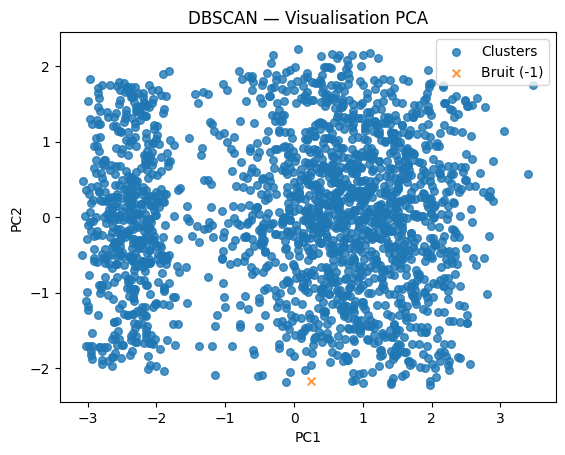

In [ ]:

# Visualisation dans l'espace PCA (bruit = étiquette -1)
plt.figure()
mask_core = labels_db != -1
plt.scatter(X_pca[mask_core, 0], X_pca[mask_core, 1], s=30, alpha=0.8, label="Clusters")
plt.scatter(X_pca[~mask_core, 0], X_pca[~mask_core, 1], s=30, alpha=0.8, marker="x", label="Bruit (-1)")
plt.title("DBSCAN — Visualisation PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()



On voit ici que le nombre de bruit est réduit. On recrée




In [ ]:
df['Cluster_DBSCAN'] = labels_db
df.head()


,Age,Gender,Hydration_Level,Oil_Level,Sensitivity,Humidity,Temperature,Skin_Type,Gender_encoded,Skin_Type_encoded,Cluster_DBSCAN
0,36,Male,0,0,2,31.9,10.1,Dry,1,1,0
1,36,Female,2,0,2,30.1,20.5,Combination,0,0,1
2,34,Female,2,1,0,53.0,19.5,Normal,0,2,1
3,51,Male,1,2,0,57.3,22.7,Oily,1,3,0
4,36,Male,2,1,1,64.4,24.0,Normal,1,2,0


Train / test split --> règle des 20 - 80

In [ ]:
X = features_scaled
y = df['Skin_Type_encoded']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, #20% de test
    random_state=42,
    stratify=y
)

Les modèles de classifications



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.995
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       1.00      1.00      1.00       100
           2       0.99      1.00      1.00       100
           3       0.99      1.00      1.00       100

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print(classification_report(y_test, gb_pred))

Gradient Boosting Accuracy: 0.9925
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       1.00      1.00      1.00       100
           2       0.98      1.00      0.99       100
           3       0.99      1.00      1.00       100

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))


XGBoost Accuracy: 0.9975
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       1.00      1.00      1.00       100
           2       0.99      1.00      1.00       100
           3       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [ ]:
{
    "RandomForest": accuracy_score(y_test, rf_pred),
    "GradientBoosting": accuracy_score(y_test, gb_pred),
    "XGBoost": accuracy_score(y_test, xgb_pred),
}


{'RandomForest': 0.995, 'GradientBoosting': 0.9925, 'XGBoost': 0.9975}

Le modèle XGBoost est celui qui nous donne les meilleures performances.

Pour comprendre on va regarder l'importance des features sur le XGBoost.

--- Importance des Features (XGBoost) ---
Sensitivity        0.332168
Oil_Level          0.325371
Hydration_Level    0.181973
Temperature        0.088231
Humidity           0.068572
Age                0.002583
Gender_encoded     0.001103
dtype: float32


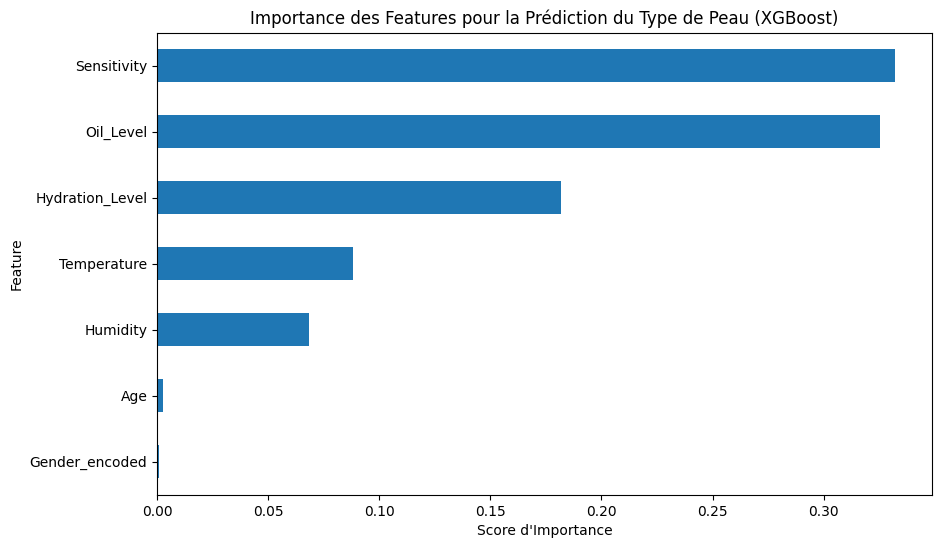

In [ ]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [
    'Age', 'Hydration_Level', 'Oil_Level', 'Sensitivity',
    'Humidity', 'Temperature', 'Gender_encoded'
]

importances = xgb.feature_importances_

feature_importances = pd.Series(importances, index=feature_names)

feature_importances = feature_importances.sort_values(ascending=False)

print("--- Importance des Features (XGBoost) ---")
print(feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.title('Importance des Features pour la Prédiction du Type de Peau (XGBoost)')
plt.xlabel('Score d\'Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

On peut en déduire que la santé/composition de la peau, soit la sensibilité, le niveau de sébum/huile, niveau d'hydratation dominent très largement le processus de classification.

Modifier les paramètres de XGBoost et voir les résultats.

Plus poussé --> donner les paramètres à l'IA et toutes les infos, lui demander une analyse et ensuite des pistes d'amélioration.

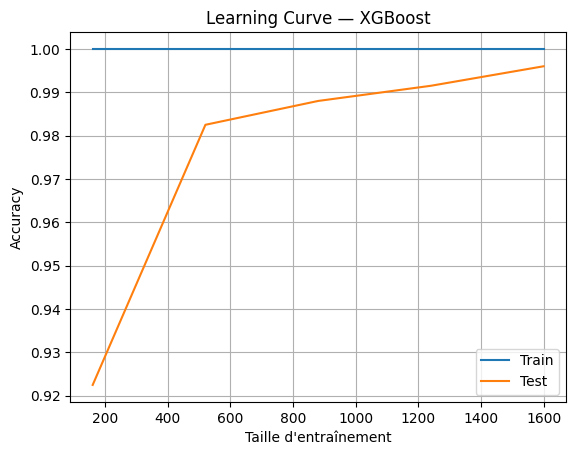

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train")
plt.plot(train_sizes, test_mean, label="Test")
plt.xlabel("Taille d'entraînement")
plt.ylabel("Accuracy")
plt.title("Learning Curve — XGBoost")
plt.legend()
plt.grid()
plt.show()


Analyse de la courbe d’apprentissage

* La courbe d’apprentissage permet d’évaluer le comportement du modèle XGBoost lorsque la quantité de données d’entraînement augmente.

* La courbe d’entraînement montre dans quelle mesure le modèle apprend sur les exemples qu’il connaît.

* La courbe de test montre sa capacité à généraliser sur de nouvelles données.

En interprétant la distance entre les deux courbes :

* Si la courbe d’entraînement est très élevée et celle du test beaucoup plus basse, cela indique de l’overfitting.

* Si les deux courbes restent basses, cela indique de l’underfitting.

* Si les deux courbes sont proches et atteignent une performance élevée, alors le modèle généralise bien, ce qui signifie qu’il est correctement réglé.

elle convertit les mesures brutes d'un nouveau client en un diagnostic dermatologique précis, en automatisant le prétraitement des données et l'application du modèle XGBoost optimisé.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# liste de param à tester
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9],
    'reg_lambda': [0.1, 1]
}

#objet gboost
xgb_gs = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# test toute les combinaisons possible
grid_search = GridSearchCV(
    estimator=xgb_gs,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 3. Lancement de l'entraînement sur 80% de données
grid_search.fit(X_train, y_train)

print("\n--- Top des réglages trouvés par l'IA ---")
print("Meilleur score pendant l'entraînement : {:.4f}".format(grid_search.best_score_))
print("Voici les paramètres idéaux :", grid_search.best_params_)

# 5. On test sur 20% de donnée inconnues !!
best_xgb = grid_search.best_estimator_
best_xgb_pred = best_xgb.predict(X_test)

# score final comparaison entre ce que l'IA a deviné et la réalité
final_accuracy = accuracy_score(y_test, best_xgb_pred)
print("Précision réelle du modèle sur les données de test : {:.4f}".format(final_accuracy))

Fitting 3 folds for each of 108 candidates, totalling 324 fits

--- Top des réglages trouvés par l'IA ---
Meilleur score pendant l'entraînement : 0.9931
Voici les paramètres idéaux : {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.1, 'subsample': 0.7}
Précision réelle du modèle sur les données de test : 0.9875


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:53:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import numpy as np
import pandas as pd

def predict_skin_type_xgboost(age, hydration, oil, sensitivity, humidity, temp, gender_enc):
    """
    IA Prédictive basée sur le meilleur modèle XGBoost après GridSearchCV.
    """
    donnees_brutes = np.array([[age, hydration, oil, sensitivity, humidity, temp, gender_enc]])

    donnees_scalees = scaler.transform(donnees_brutes)

    #Prédiction avec le modèle optimisé
    prediction_code = best_xgb.predict(donnees_scalees)[0]

    # trad du code en texte
    type_peau = le_skin.inverse_transform([prediction_code])[0]

    proba = best_xgb.predict_proba(donnees_scalees)[0][prediction_code]

    return type_peau, proba

# --- EXEMPLE DE TEST ---
# Imaginons un nouveau profil : 30 ans, Hydratation 1 (Medium), Huile 2 (High), Sensibilité 0, Humidité 55%, Temp 20°C, Homme (1)

#test d'une vrai valeur du tableau
resultat, confiance = predict_skin_type_xgboost(30, 1, 2, 0, 55.0, 20.0, 1)

# TEST PEAU GRASSE (OILY)
res_oily, conf_oily = predict_skin_type_xgboost(25, 1, 2, 0, 60.0, 25.0, 0)
print(f"Test Grasse    -> Résultat: {res_oily:<12} | Confiance: {conf_oily:.2%}")

# TEST PEAU SÈCHE (DRY)
res_dry, conf_dry = predict_skin_type_xgboost(45, 0, 0, 2, 30.0, 10.0, 0)
print(f"Test Sèche     -> Résultat: {res_dry:<12} | Confiance: {conf_dry:.2%}")

# TEST PEAU MIXTE (COMBINATION)
res_comb, conf_comb = predict_skin_type_xgboost(36, 2, 0, 2, 30.1, 20.5, 0)
print(f"Test Mixte     -> Résultat: {res_comb:<12} | Confiance: {conf_comb:.2%}")

# TEST PEAU NORMALE (NORMAL)
res_norm, conf_norm = predict_skin_type_xgboost(34, 2, 1, 0, 53.0, 19.5, 0)
print(f"Test Normale   -> Résultat: {res_norm:<12} | Confiance: {conf_norm:.2%}")



Test Grasse    -> Résultat: Oily         | Confiance: 65.55%
Test Sèche     -> Résultat: Dry          | Confiance: 65.63%
Test Mixte     -> Résultat: Combination  | Confiance: 65.51%
Test Normale   -> Résultat: Normal       | Confiance: 65.89%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import joblib

joblib.dump(best_xgb, 'modele_peau_xgboost.pkl')
joblib.dump(scaler, 'scaler_peau.pkl')
joblib.dump(le_skin, 'label_encoder_peau.pkl')

['label_encoder_peau.pkl']

#Analyse du dataset Skincare Products and their Ingredients

In [ ]:
dfskincare = pd.read_csv('skincare_products.csv')
dfskincare


,product_name,product_url,product_type,ingredients,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"Aqua/Water, Homosalate, Glycerin, Octocrylene,...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"Purified Water, Glycerin, Ceteareth-20 and Cet...",£16.00
...,...,...,...,...,...
1133,Elemis Life Elixirs Embrace Bath and Shower El...,https://www.lookfantastic.com/elemis-life-elix...,Bath Oil,"Prunus Amygdalus Dulcis (Sweet Almond) Oil, TI...",£55.00
1134,Love Boo Splendidly Soothing Bath Soak (250ml),https://www.lookfantastic.com/love-boo-splendi...,Bath Oil,"Aqua, sodium lauroyl sarcosinate, sodium cocoa...",£10.99
1135,Elemis Life Elixirs Fortitude Bath and Shower ...,https://www.lookfantastic.com/elemis-life-elix...,Bath Oil,"Prunus Amygdalus Dulcis (Sweet Almond) Oil, TI...",£55.00
1136,Connock London Kukui Oil Soothing Bath & Showe...,https://www.lookfantastic.com/connock-london-k...,Bath Oil,"Caprylic/Capric Triglyceride, PEG-40 Sorbitan ...",£36.00


Nettoyage --> ok

In [ ]:
dfskincare.isnull().sum()

,0
product_name,0
product_url,0
product_type,0
ingredients,0
price,0


In [ ]:
dfskincare.duplicated().sum()

np.int64(0)

Exploration rapide du dataset

In [ ]:
dfskincare.describe()
dfskincare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1138 non-null   object
 1   product_url   1138 non-null   object
 2   product_type  1138 non-null   object
 3   ingredients   1138 non-null   object
 4   price         1138 non-null   object
dtypes: object(5)
memory usage: 44.6+ KB


Distribuion des types de produits

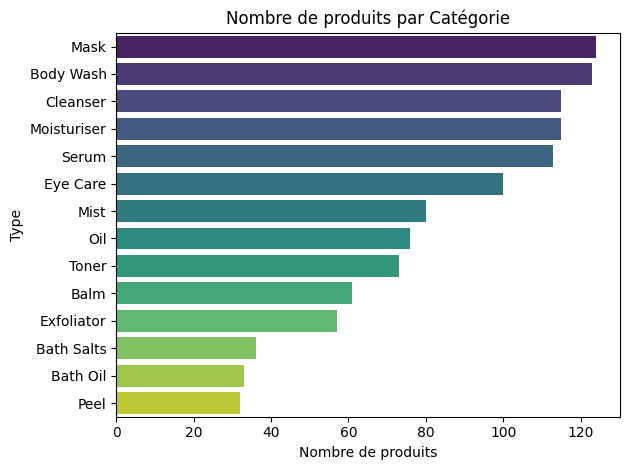

In [ ]:
plt.figure()
type_counts = dfskincare['product_type'].value_counts()
sns.barplot(x=type_counts.values, y=type_counts.index, palette='viridis', hue=type_counts.index, legend=False)
plt.title('Nombre de produits par Catégorie')
plt.xlabel('Nombre de produits')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

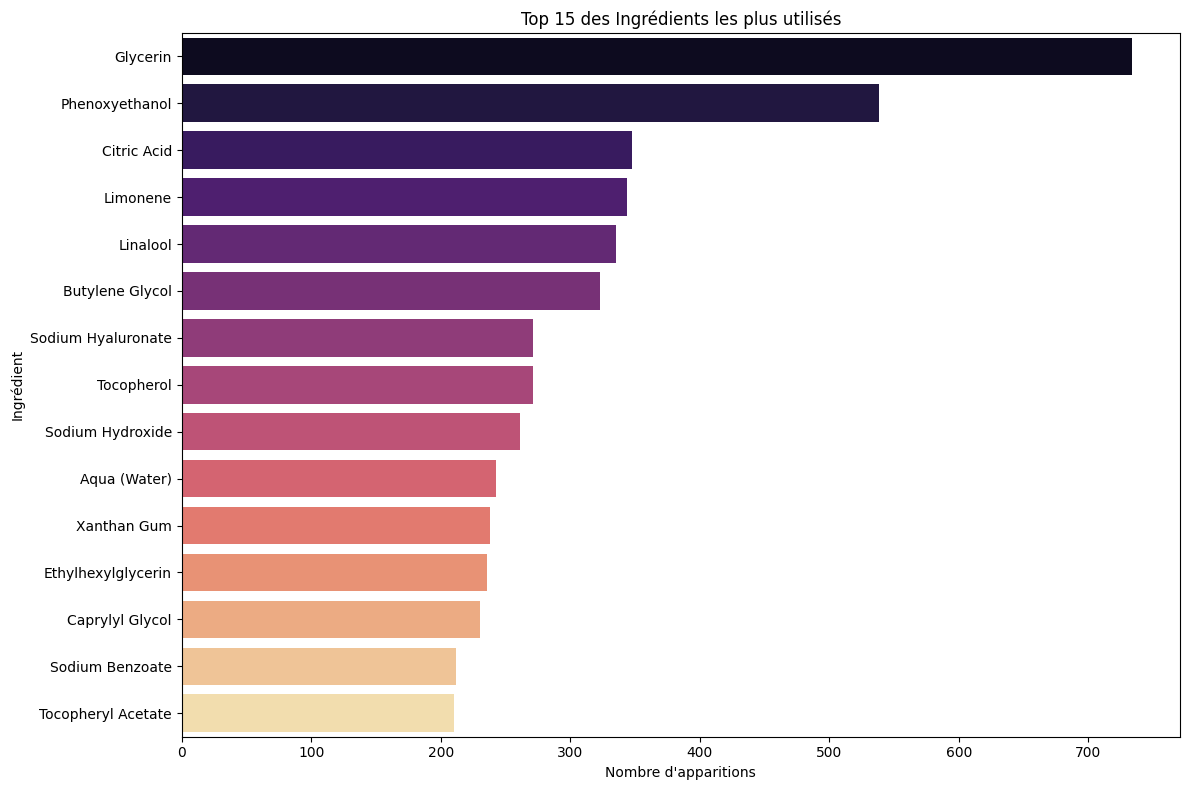

In [ ]:
plt.figure(figsize=(12, 8))

ingredients_series = dfskincare['ingredients'].dropna().str.split(',').explode().str.strip()

# On compte les 15 plus fréquents
top_ingredients = ingredients_series.value_counts().head(15)

sns.barplot(x=top_ingredients.values, y=top_ingredients.index, palette='magma', hue=top_ingredients.index, legend=False)
plt.title('Top 15 des Ingrédients les plus utilisés')
plt.xlabel('Nombre d\'apparitions')
plt.ylabel('Ingrédient')
plt.tight_layout()
plt.show()